In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from portfolio_env_framework import *
import random
import torch
import numpy.typing as npt
import gymnasium as gym

## Test

In [2]:
class BasicDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+1), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
        # get times and dickers
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.vol_20 = idx_df.vol_20
        self.vol_60 = idx_df.vol_60
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix_df = vix_df.vix
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        s = np.zeros((self.universe_size+1, 100+1))
        s[:, 0] = w
        # s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[1:, :-1] = self.ret.loc[self.times[t:t+100], :].to_numpy().T # 100 past returns, up to yesterday
        s[-1, 1] = self.vol_20[self.times[t+100-1]] # yesterday's vol_20
        s[-1, 2] = self.vol_20[self.times[t+100-1]] / self.vol_60[self.times[t+100-1]] # yesterday's vol ratio
        s[-1, 3] = self.vix_df[self.times[t+100-1]] # yesterday's vix
        return s

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        return np.append(self.stock_df.loc[self.times[t+100], :].to_numpy().flatten(), 1.0)

In [3]:
class DifferentialSharpeRatioReward(AbstractRewardManager):
    def __init__(self, eta: float = 1/252):
        self.eta = eta
        self.initialize_reward()

    def initialize_reward(self):
        self.A, self.B = 0.0, 0.0

    def compute_reward(self, old_port_val: float, new_port_val: float) -> float:
        R = np.log(new_port_val / old_port_val)
        dA = R - self.A
        dB = R ** 2 - self.B
        if self.B - self.A ** 2 == 0:
            D = 0
        else:
            D = (self.B * dA - 0.5 * self.A * dB) / (self.B - self.A ** 2) ** (3 / 2)
        self.A += self.eta * dA
        self.B += self.eta * dB
        return D

In [4]:
# Parallel environments
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': BasicDataManager(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0.10/365,
    'cs': 0.10/365
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model_framework")

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 468  |
|    iterations      | 1    |
|    time_elapsed    | 17   |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.41e+03    |
|    ep_rew_mean          | 6.54e+03    |
| time/                   |             |
|    fps                  | 359         |
|    iterations           | 2           |
|    time_elapsed         | 45          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.025918122 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 1.42e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.196       |
|    n_updates            | 10          |
|    policy_grad

In [9]:
class TestBasicDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+1), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
        # get times and dickers
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        self.vol_20 = idx_df.vol_20
        self.vol_60 = idx_df.vol_60
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix_df = vix_df.vix
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        s = np.zeros((self.universe_size+1, 100+1))
        s[:, 0] = w
        # s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[1:, :-1] = self.ret.loc[self.times[t:t+100], :].to_numpy().T # 100 past returns, up to yesterday
        s[-1, 1] = self.vol_20[self.times[t+100-1]] # yesterday's vol_20
        s[-1, 2] = self.vol_20[self.times[t+100-1]] / self.vol_60[self.times[t+100-1]] # yesterday's vol ratio
        s[-1, 3] = self.vix_df[self.times[t+100-1]] # yesterday's vix
        return s

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        return np.append(self.stock_df.loc[self.times[t+100], :].to_numpy().flatten(), 1.0)

In [10]:
env = PortfolioEnvWithTCost(dm=TestBasicDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.10/365, cs=0.10/365)
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+100]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+100])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+100]].vwretd.values[0]))
    if terminated:
        break

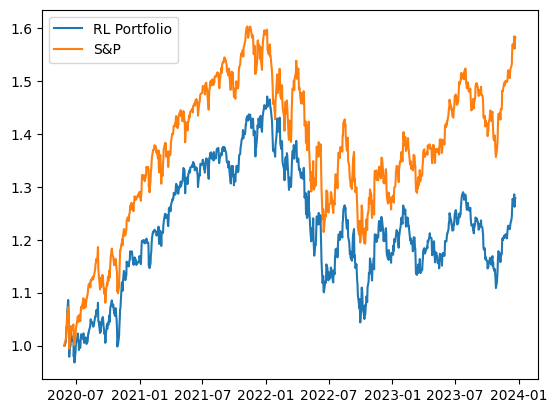

In [12]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [13]:
min(mus), max(mus)

(0.9995167124420706, 0.9998240884067789)

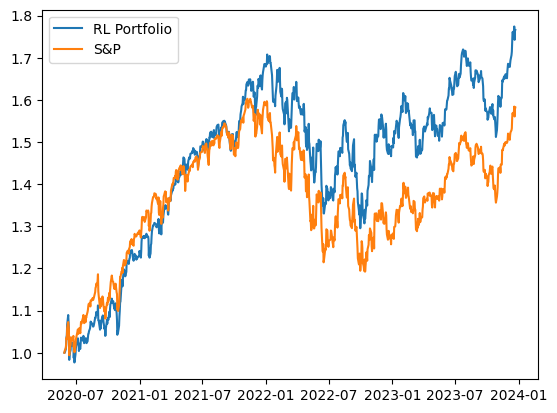

In [14]:
plt.plot(times_arr, np.array(port_val) / np.array([1, *mus]).cumprod(), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## New

In [ ]:
class PortfolioEnvWithTCost(AbstractPortfolioEnvWithTCost):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+1), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
    
        # create stock array
        pivot_price_df = df.pivot(index='date', columns='TICKER', values='PRC')
        stock_array = pivot_price_df.values.astype(float)
        
        # adjust for stock splits
        pivot_facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR')
        facpr_array = pivot_facpr_df.values.astype(float)
        self.stock_array = stock_array * (1+facpr_array).cumprod(axis=0)
        self.ret = np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :])
    
        # get times and dickers
        self.times = df.date.unique()[100:]
        self.tickers = df.TICKER.unique()
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.vol_20 = idx_df.loc[self.times].vol_20.values
        self.vol_60 = idx_df.loc[self.times].vol_60.values
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix = vix_df.loc[self.times].vix.values
        
        return len(self.times)-1, len(self.tickers)
    
    def get_state(self) -> npt.NDArray[float]:
        s = np.zeros((self.universe_size+1, 100+1))
        s[:, 0] = self.w
        s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[-1, 1] = self.vol_20[self.t]
        s[-1, 2] = self.vol_20[self.t] / self.vol_60[self.t]
        s[-1, 3] = self.vix[self.t]
        return s

    def get_prices(self) -> npt.NDArray[float]:
        return np.append(self.stock_array[self.t+100, :].flatten(), 1.0)

In [ ]:
# Parallel environments
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4)

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model")

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 1879 |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.42e+03    |
|    ep_rew_mean          | 39.6        |
| time/                   |             |
|    fps                  | 1049        |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.017226238 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0.0133      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.399       |
|    n_updates            | 10          |
|    policy_grad

In [ ]:
class TestPortfolioEnvWithTCost(AbstractPortfolioEnvWithTCost):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+1), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
        # create stock array
        pivot_price_df = df.pivot(index='date', columns='TICKER', values='PRC')
        stock_array = pivot_price_df.values.astype(float)
        
        # adjust for stock splits
        pivot_facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR')
        facpr_array = pivot_facpr_df.values.astype(float)
        self.stock_array = stock_array * (1+facpr_array).cumprod(axis=0)
        self.ret = np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :])
    
        # get times and dickers
        self.times = df.date.unique()[100:]
        self.tickers = df.TICKER.unique()
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        self.vol_20 = idx_df.loc[self.times].vol_20.values
        self.vol_60 = idx_df.loc[self.times].vol_60.values
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix = vix_df.loc[self.times].vix.values
        
        return len(self.times)-1, len(self.tickers)
    
    def get_state(self) -> npt.NDArray[float]:
        s = np.zeros((self.universe_size+1, 100+1))
        s[:, 0] = self.w
        s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[-1, 1] = self.vol_20[self.t]
        s[-1, 2] = self.vol_20[self.t] / self.vol_60[self.t]
        s[-1, 3] = self.vix[self.t]
        return s

    def get_prices(self) -> npt.NDArray[float]:
        return np.append(self.stock_array[self.t+100, :].flatten(), 1.0)
    
    def step(self, action: npt.NDArray[float]) -> tuple:
        action = action / action.sum()
        self.w_new = action
        self.t += 1
        self.v_new = self.get_prices()
        self.y = self.v_new / self.v
        self.mu = self.find_mu(self.w, self.w_new)
        self.new_port_val = self.port_val * self.mu * (self.y @ self.w)
        print(f"ret={self.new_port_val/self.port_val}")
        print(f"{self.v[35]=}, {self.v_new[35]=}")
        print(f"{self.w.max()=}, {action.max()=}")
        print(f"{self.y.max()=}")

        self.reward = self.compute_reward()

        self.state = self.get_state()
        self.w = self.w_new
        self.v = self.v_new
        self.port_val = self.new_port_val

        if self.logging:
            info = {
                'port_val': self.port_val
            }
        else:
            info = {}

        finished = (self.t == self.num_time_periods)
        return self.state.copy(), self.reward, finished, False, info

In [ ]:
env = TestPortfolioEnvWithTCost()
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.idx_df[env.idx_df.index == env.times[env.t]].vwretd.values[0]))
    if terminated:
        break

ret=1.0
self.v[35]=7.29, self.v_new[35]=6.78
self.w.max()=1.0, action.max()=0.089942776
self.y.max()=1.03453917469551
ret=1.0051864644691566
self.v[35]=6.78, self.v_new[35]=6.57
self.w.max()=0.089942776, action.max()=0.07140924
self.y.max()=1.0487992104397412
ret=1.0047548874085077
self.v[35]=6.57, self.v_new[35]=6.76
self.w.max()=0.07140924, action.max()=0.079876
self.y.max()=1.067590987868284
ret=1.0121157872277908
self.v[35]=6.76, self.v_new[35]=7.05
self.w.max()=0.079876, action.max()=0.068721056
self.y.max()=1.0614574187884107
ret=1.0134537322336392
self.v[35]=7.05, self.v_new[35]=7.36
self.w.max()=0.068721056, action.max()=0.066253595
self.y.max()=1.1486209613869187
ret=1.0066270184756703
self.v[35]=7.36, self.v_new[35]=7.74
self.w.max()=0.066253595, action.max()=0.08491319
self.y.max()=1.0643335643335645
ret=1.0247924333537386
self.v[35]=7.74, self.v_new[35]=7.88
self.w.max()=0.08491319, action.max()=0.05854438
self.y.max()=1.1546982927147138
ret=1.019185189110941
self.v[35]=7.8

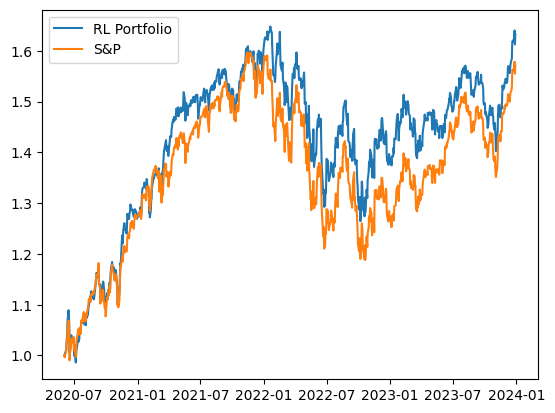

In [ ]:
plt.plot(env.times[5:], np.array(port_val), label='RL Portfolio')
plt.plot(env.times[5:], np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## Old

In [ ]:
class PortfolioEnvWithTCost(AbstractPortfolioEnvWithTCost):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+1), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO']]
        df.date = pd.to_datetime(df.date)
        df.astype({
          'PRC': float,
          'VOL': float,
          'ASKHI': float,
          'BIDLO': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
    
        # create numpy array
        pivot_df = df.pivot(index='date', columns='TICKER', values='PRC')
        self.stock_array = pivot_df.values.astype(float)
        self.ret = np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :])
    
        # get times and dickers
        self.times = df.date.unique()[100:]
        self.tickers = df.TICKER.unique()
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.vol_20 = idx_df.loc[self.times].vol_20.values
        self.vol_60 = idx_df.loc[self.times].vol_60.values
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix = vix_df.loc[self.times].vix.values
        
        return len(self.times)-1, len(self.tickers)
    
    def get_state(self) -> npt.NDArray[float]:
        s = np.zeros((self.universe_size+1, 100+1))
        s[:, 0] = self.w
        s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[-1, 1] = self.vol_20[self.t]
        s[-1, 2] = self.vol_20[self.t] / self.vol_60[self.t]
        s[-1, 3] = self.vix[self.t]
        return s

    def get_prices(self) -> npt.NDArray[float]:
        return np.append(self.stock_array[self.t+100, :].flatten(), 1.0)

In [ ]:
# Parallel environments
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4)

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2564 |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 8192 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.42e+03   |
|    ep_rew_mean          | 51.6       |
| time/                   |            |
|    fps                  | 837        |
|    iterations           | 2          |
|    time_elapsed         | 19         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.02301747 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -121       |
|    explained_variance   | 0.0134     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.326      |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0414

In [ ]:
class TestPortfolioEnvWithTCost(AbstractPortfolioEnvWithTCost):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+1), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO']]
        df.date = pd.to_datetime(df.date)
        df.astype({
          'PRC': float,
          'VOL': float,
          'ASKHI': float,
          'BIDLO': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
        # create numpy array
        pivot_df = df.pivot(index='date', columns='TICKER', values='PRC')
        self.stock_array = pivot_df.values.astype(float)
        self.ret = np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :])
    
        # get times and dickers
        self.times = df.date.unique()[100:]
        self.tickers = df.TICKER.unique()
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        self.vol_20 = idx_df.loc[self.times].vol_20.values
        self.vol_60 = idx_df.loc[self.times].vol_60.values
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix = vix_df.loc[self.times].vix.values
        
        return len(self.times)-1, len(self.tickers)
    
    def get_state(self) -> npt.NDArray[float]:
        s = np.zeros((self.universe_size+1, 100+1))
        s[:, 0] = self.w
        s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[-1, 1] = self.vol_20[self.t]
        s[-1, 2] = self.vol_20[self.t] / self.vol_60[self.t]
        s[-1, 3] = self.vix[self.t]
        return s

    def get_prices(self) -> npt.NDArray[float]:
        return np.append(self.stock_array[self.t+100, :].flatten(), 1.0)
    
    def step(self, action: npt.NDArray[float]) -> tuple:
        action = action / action.sum()
        self.w_new = action
        self.t += 1
        self.v_new = self.get_prices()
        self.y = self.v_new / self.v
        self.mu = self.find_mu(self.w, self.w_new)
        self.new_port_val = self.port_val * self.mu * (self.y @ self.w)
        print(f"ret={self.new_port_val/self.port_val}")
        print(f"{self.v[35]=}, {self.v_new[35]=}")
        print(f"{self.w.max()=}, {action.max()=}")
        print(f"{self.y.max()=}")

        self.reward = self.compute_reward()

        self.state = self.get_state()
        self.w = self.w_new
        self.v = self.v_new
        self.port_val = self.new_port_val

        if self.logging:
            info = {
                'port_val': self.port_val
            }
        else:
            info = {}

        finished = (self.t == self.num_time_periods)
        return self.state.copy(), self.reward, finished, False, info

In [ ]:
env = TestPortfolioEnvWithTCost()
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []

for i in range(900):
    print(f"{i=}")
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.idx_df[env.idx_df.index == env.times[env.t]].vwretd.values[0]))
    if terminated:
        break

i=0
ret=1.0
self.v[35]=7.29, self.v_new[35]=6.78
self.w.max()=1.0, action.max()=0.09505391
self.y.max()=1.03453917469551
i=1
ret=0.9960662713784137
self.v[35]=6.78, self.v_new[35]=6.57
self.w.max()=0.09505391, action.max()=0.09424204
self.y.max()=1.0487992104397412
i=2
ret=1.00010549301127
self.v[35]=6.57, self.v_new[35]=6.76
self.w.max()=0.09424204, action.max()=0.050506644
self.y.max()=1.067590987868284
i=3
ret=1.009918620856994
self.v[35]=6.76, self.v_new[35]=7.05
self.w.max()=0.050506644, action.max()=0.076511495
self.y.max()=1.0614574187884107
i=4
ret=1.0185529254954304
self.v[35]=7.05, self.v_new[35]=7.36
self.w.max()=0.076511495, action.max()=0.057633374
self.y.max()=1.1486209613869187
i=5
ret=0.9996681789432706
self.v[35]=7.36, self.v_new[35]=7.74
self.w.max()=0.057633374, action.max()=0.085578054
self.y.max()=1.0643335643335645
i=6
ret=1.0342625710347026
self.v[35]=7.74, self.v_new[35]=7.88
self.w.max()=0.085578054, action.max()=0.058647756
self.y.max()=1.1546982927147138
i=7


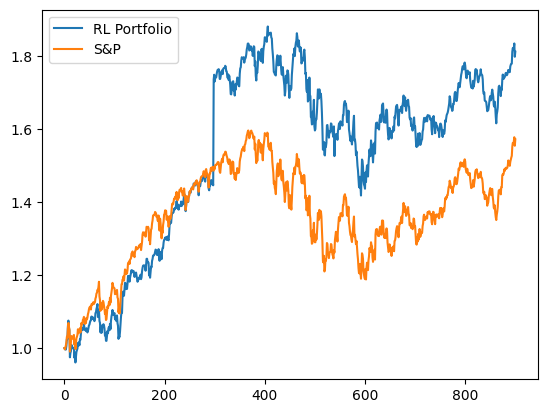

In [ ]:
plt.plot(np.array(port_val), label='RL Portfolio')
plt.plot(np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
port_val = np.array(port_val)

In [ ]:
np.where(np.diff(port_val) == np.diff(port_val).max())

(array([297], dtype=int64),)

In [ ]:
env.tickers[34]

'DUK'

In [ ]:
np.where(ys[297] == ys[297].max())

(array([35], dtype=int64),)

In [ ]:
np.where(actions[296] == max(actions[296]))

(array([44], dtype=int64),)

In [ ]:
actions[296][44]

0.20295541

In [ ]:
ys[297][44]

0.9959810251680062

In [ ]:
actions[296][35]

0.09129767

In [ ]:
env.tickers[36]

'MCD'

In [ ]:
env.times[296]

Timestamp('2021-07-29 00:00:00')

In [ ]:
port_val[297], port_val[298]

(1.4466545596350437, 1.7372477665688328)

In [ ]:
actions[297] @ ys[297] / sum(actions[297])

0.9973219609962936

In [ ]:
actions[296] @ ys[296] / sum(actions[296])

0.991770911483657

In [ ]:
actions[298] @ ys[298] / sum(actions[298])

1.0100323748587503

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('crsp_snp100_2010_to_2024.csv')

C:\Users\sumit\AppData\Local\Temp\ipykernel_10536\2974873832.py:1: DtypeWarning: Columns (6,9,19,22,24,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('crsp_snp100_2010_to_2024.csv')


In [ ]:
df = df[df.TICKER.isin(tickers)]

In [ ]:
(pd.notnull(df.FACPR) & (df.FACPR != 0.0)).sum()

38

In [ ]:
df.date = pd.to_datetime(df.date)

In [ ]:
df = df[(df.date.dt.year == 2021) & ((df.date.dt.month == 7) | (df.date.dt.month == 8)) & (df.TICKER == 'MCD')]

In [ ]:
df[['date', 'PRC']].head(30)

,date,PRC
161203,2021-07-01,232.27000
161204,2021-07-02,233.63000
161205,2021-07-06,232.75000
161206,2021-07-07,234.63000
161207,2021-07-08,232.84000
161208,2021-07-09,235.67999
161209,2021-07-12,235.61000
161210,2021-07-13,236.17000
161211,2021-07-14,237.13000
161212,2021-07-15,236.88000


In [ ]:
df = pd.read_csv('crsp_snp100_2010_to_2024.csv')

C:\Users\sumit\AppData\Local\Temp\ipykernel_8812\2974873832.py:1: DtypeWarning: Columns (6,9,19,22,24,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('crsp_snp100_2010_to_2024.csv')


In [ ]:
# convert datatypes
df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
df.date = pd.to_datetime(df.date)
df.FACPR = df.FACPR.fillna(0.0)
df.astype({
    'PRC': float,
    'VOL': float,
    'ASKHI': float,
    'BIDLO': float,
    'FACPR': float
})

# drop duplicates and nans
df = df.drop_duplicates(subset=['date', 'TICKER'])
df.dropna(inplace=True)

In [ ]:
# only include stocks that are present in all dates
ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
def is_max_val_count(ticker: str) -> bool:
  return ticker_ok[ticker]
ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
df = df[ok]
df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2024)]

# # create stock array
# pivot_price_df = df.pivot(index='date', columns='TICKER', values='PRC')
# stock_array = pivot_price_df.values.astype(float)
# 
# # adjust for stock splits
# pivot_facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR')
# facpr_array = pivot_facpr_df.values.astype(float)
# stock_array = stock_array / (1+facpr_array).cumprod(axis=0)
# 
# # np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :])
# ret = np.log((stock_array[1:] - stock_array[:-1]) / stock_array[:-1] + 1)

# create stock array
stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)

# adjust for stock splits
facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
stock_df = stock_df * (1+facpr_df).cumprod(axis=0)
# assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
ret = np.log(stock_df.pct_change().iloc[1:, :] + 1)

In [ ]:
ret.max().max()

0.42061691312876653

In [ ]:
ret[ret.max(axis=1) == ret.max().max()]

TICKER,AAPL,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,AVGO,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2016-04-22,-0.00274,0.004548,-0.00464,-0.016531,0.011995,0.420617,-0.007083,0.015671,-0.01678,-0.006762,...,-0.003063,0.008761,0.026111,0.005035,0.017238,-0.021014,0.01034,0.011324,0.003645,0.00849


In [ ]:
stock_df.loc[(stock_df.index > '2021-07-28') & (stock_df.index < '2021-08-03'), 'GE']

date
2021-07-29    13.290
2021-07-30    12.950
2021-08-02    12.575
Name: GE, dtype: float64